# Covid Vaccine Study

Data: 
- 5' GEX, VDJ, Antibody Capture, and CiteSeq data in various combination

In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os

import scanpy as sc
import scirpy as ir
import anndata as ann

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from matplotlib import rcParams

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%autoreload 2
import sys
sys.path.append('..')

import utils.annotation as utils_annotation
import utils.representation as utils_representation
import utils.visualisation as utils_vis

In [4]:
sc.settings.set_figure_params(dpi=150)
sc.settings.verbosity = 3
sc.set_figure_params(vector_friendly=True, color_map='viridis', transparent=True)
sb.set_style('whitegrid')
#sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

## Settings

In [5]:
path_base = '../../data/20231017'
path_merged = f'{path_base}/01_mixed_merged_1.h5ad'

## Sample 1
- MVP d189 215° (HA1, ca. 1,500 cells)
    + Dextramers: LTD, QPY, TFE
    + Cite: TotalSeq™-C Human Universal Cocktail von Biolegend
    
- Donor A7 d189 3° (HA2, ca 1,500 cells)
    + Dextramers: LTD, YLQ, RLQ, VLN, KIA, QPY, TFE
    + Cite: TotalSeq™-C Human Universal Cocktail von Biolegend
    
- Donor A15 d189 3° (HA3, ca 1,500 cells)
    + Dextramers: LTD, YTN, NYN, QPY, TFE
    + Cite: TotalSeq™-C Human Universal Cocktail von Biolegend

- Donor A15 d108 3° (HA4)
    + Dextramers: LTD, NYN, QPY, TFE
    + Cite: CD62L, CCR7, CD45RA, CXCR3

- MVP d157 215° (HA5, ca. 500 cells)
    + Dextramers: ATD, CTE, FLR, RAK
    + Cite: CD62L, CCR7, CD45RA, CXCR3

- Donor A7 extra timepoint (HA6, ca. 500 cells)
    + Dextramers: ATD, CTE, FLR, RAK
    + Cite: CD62L, CCR7, CD45RA, CXCR3

- Donor A15 extra timepoint (HA7, ca. 500 cells)
    + Dextramers: ATD, CTE, FLR, RAK
    + Cite: CD62L, CCR7, CD45RA, CXCR3

In [6]:
hashtags = [f'HA{i}' for i in range(1, 8)]

epitope_ids = ['LTDEMIAQY', 'QPYRVVVL', 'YLQPRTFLL', 'RLQSLQTYV', 'VLNDILSRL', 
               'KIADYNYKL', 'YTNSFTRGVY', 'NYNYLYRLF', 'TFEYVSQPFLMDLE', 
               'ATDSLNNEY', 'CTELKLSDY', 'FLRGRAYGL', 'RAKFKQLL']

costum_cite = ['CCR7']
cite_seqs = ['Hu.CD101', 'Hu.CD103', 'Hu.CD105_43A3', 'Hu.CD107a', 'Hu.CD112', 'Hu.CD119', 'Hu.CD11a',
 'Hu.CD11b', 'Hu.CD11c', 'Hu.CD122', 'Hu.CD123', 'Hu.CD124', 'Hu.CD127', 'Hu.CD13', 'Hu.CD134',
 'Hu.CD137', 'Hu.CD141', 'Hu.CD146', 'Hu.CD14_M5E2', 'Hu.CD152', 'Hu.CD154', 'Hu.CD155', 'Hu.CD158',
 'Hu.CD158b', 'Hu.CD158e1', 'Hu.CD16', 'Hu.CD161', 'Hu.CD163', 'Hu.CD169', 'Hu.CD18', 'Hu.CD183',
 'Hu.CD185', 'Hu.CD19', 'Hu.CD194', 'Hu.CD195', 'Hu.CD196', 'Hu.CD1c', 'Hu.CD1d', 'Hu.CD2',
 'Hu.CD20_2H7', 'Hu.CD21', 'Hu.CD22', 'Hu.CD223', 'Hu.CD224', 'Hu.CD226_11A8', 'Hu.CD23', 'Hu.CD24',
 'Hu.CD244', 'Hu.CD25', 'Hu.CD26', 'Hu.CD267', 'Hu.CD268', 'Hu.CD27', 'Hu.CD270', 'Hu.CD272',
 'Hu.CD274', 'Hu.CD279', 'Hu.CD28', 'Hu.CD29', 'Hu.CD303', 'Hu.CD31', 'Hu.CD314', 'Hu.CD319',
 'Hu.CD32', 'Hu.CD328', 'Hu.CD33', 'Hu.CD335', 'Hu.CD35', 'Hu.CD352', 'Hu.CD36', 'Hu.CD38_HIT2',
 'Hu.CD39', 'Hu.CD3_UCHT1', 'Hu.CD40', 'Hu.CD41', 'Hu.CD42b', 'Hu.CD45RA', 'Hu.CD45RO', 'Hu.CD45_HI30',
 'Hu.CD47', 'Hu.CD48', 'Hu.CD49a', 'Hu.CD49b', 'Hu.CD49d', 'Hu.CD4_RPA.T4', 'Hu.CD5', 'Hu.CD52',
 'Hu.CD54', 'Hu.CD56', 'Hu.CD57', 'Hu.CD58', 'Hu.CD62L', 'Hu.CD62P', 'Hu.CD64', 'Hu.CD69',
 'Hu.CD7', 'Hu.CD71', 'Hu.CD73', 'Hu.CD79b', 'Hu.CD8', 'Hu.CD81', 'Hu.CD82', 'Hu.CD83',
 'Hu.CD85j', 'Hu.CD86', 'Hu.CD88', 'Hu.CD94', 'Hu.CD95', 'Hu.CD99', 'Hu.CLEC12A', 'Hu.CX3CR1',
 'Hu.FceRIa', 'Hu.GPR56', 'Hu.HLA.ABC', 'Hu.HLA.DR', 'Hu.HLA.E', 'Hu.Ig.LightChain.k', 'Hu.Ig.LightChain.l', 'Hu.IgD',
 'Hu.IgM', 'Hu.KLRG1', 'Hu.LOX.1', 'Hu.TCR.AB', 'Hu.TCR.Va7.2', 'Hu.TCR.Vd2', 'Hu.TIGIT', 'HuMs.CD44',
 'HuMs.CD49f', 'HuMs.integrin.b7', 'HuMsRt.CD278', 'Isotype_HTK888', 'Isotype_MOPC.173', 'Isotype_MOPC.21', 
 'Isotype_MPC.11', 'Isotype_RTK2071', 'Isotype_RTK2758', 'Isotype_RTK4530']

feature_barcode_ids = hashtags + epitope_ids + cite_seqs + costum_cite

In [7]:
sample = 1

# GEX data
path_gex = f'{path_base}/GEX/gex_mixed_run_{sample}_feature_bc_matrix.h5'
adata = sc.read_10x_h5(path_gex, gex_only=False)
adata.var_names_make_unique()

# VDJ data
path_vdj = f'{path_base}/VDJ/vdj_mixed_runs_{sample}_filtered_contig.csv'
adata_vdj = ir.io.read_10x_vdj(path_vdj)
ir.pp.merge_with_ir(adata, adata_vdj)


# Epitope data
adata.uns['epitopes'] = epitope_ids
for e in epitope_ids:
    adata.obs[e] = adata[:, e].X.A.copy()

# Hashtag data
adata.uns['hashtags'] = hashtags
for h in hashtags:
    adata.obs[h] = adata[:, h].X.A.copy()

# CiteSeq Data
adata.uns['cite_ids'] = cite_seqs
for c in cite_seqs + costum_cite:
    adata.obs[c] = adata[:, c].X.A.copy()
    
# Remove Barcodes from counts
adata = adata[:, [gene for gene in adata.var_names if gene not in feature_barcode_ids]]
adata.obs['sample'] = f'202310_{sample}'

adata.shape

reading ../../data/20231017/GEX/gex_mixed_run_1_feature_bc_matrix.h5
 (0:00:01)


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\ipykernel_launcher.py:31: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


(14693, 36601)

In [8]:
len([el for el in adata.obs.index if el not in adata_vdj.obs.index])

3017

## Quality Control

Basic analysis by amount counts, genes, and fraction of mitochondrial genes

In [9]:
adata.obs['n_counts'] = adata.X.A.sum(axis=1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X.A > 0).sum(axis=1)
adata.obs['log_genes'] = np.log10(adata.obs['n_genes'])

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_idx = np.where(mt_gene_mask)[0]
adata.obs['mt_frac'] = adata.X.A[:, mt_gene_idx].sum(1) / adata.X.A.sum(axis=1)

In [10]:
print('Mean # Genes: ', adata.obs['n_genes'].mean())
print('Median # Genes: ', adata.obs['n_genes'].median())
print('Mean # Counts: ', adata.obs['n_counts'].mean())
print('Median # Counts: ', adata.obs['n_counts'].median())
print('Mean % MT: ', adata.obs['mt_frac'].mean())
print('Median % MT: ', adata.obs['mt_frac'].median())

Mean # Genes:  1678.3115769414007
Median # Genes:  1560.0
Mean # Counts:  4193.97216796875
Median # Counts:  3678.0
Mean % MT:  0.038200270384550095
Median % MT:  0.036428842693567276


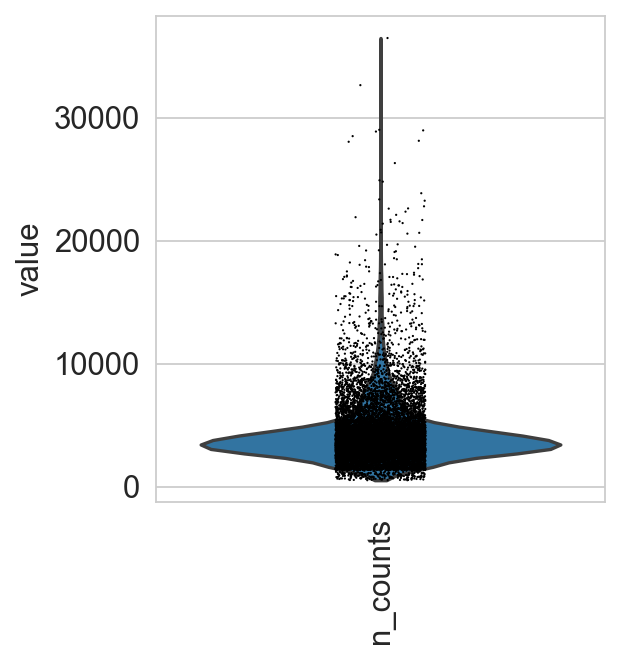

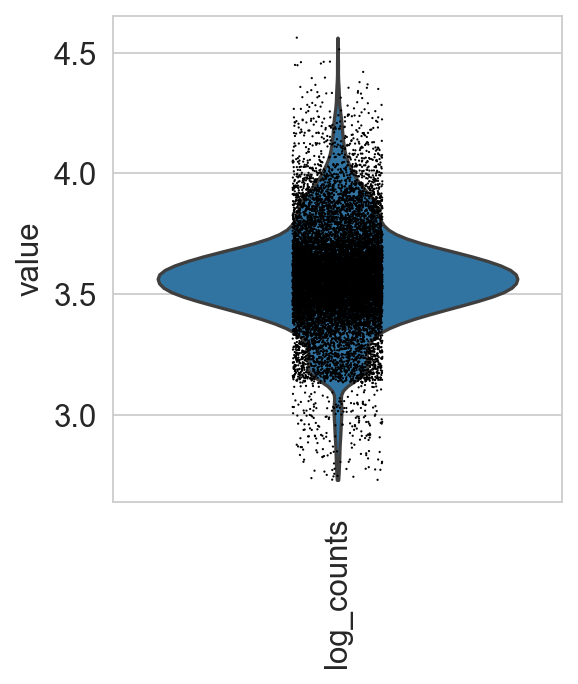

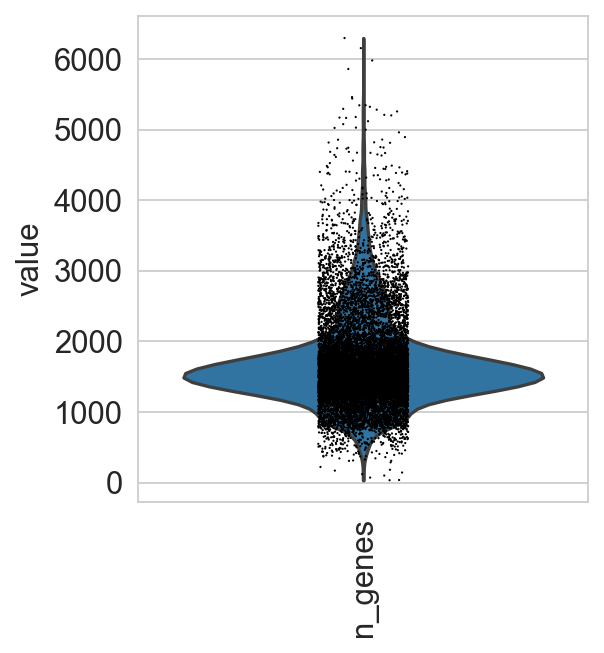

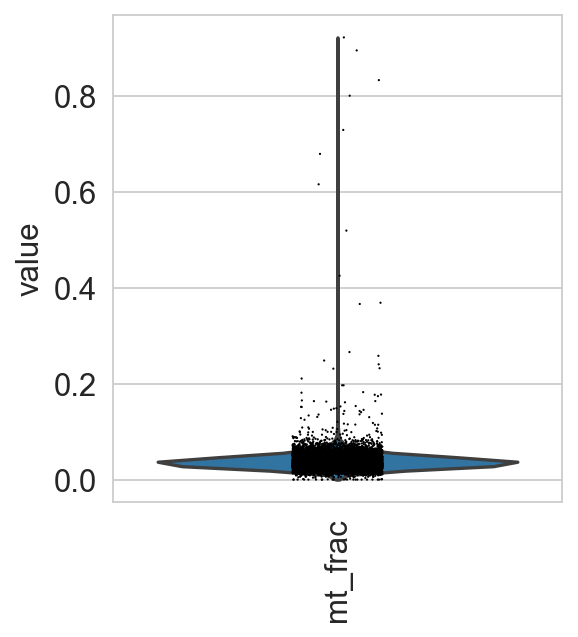

In [11]:
rcParams['figure.figsize'] = (4, 4)
sc.pl.violin(adata, ['n_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90)

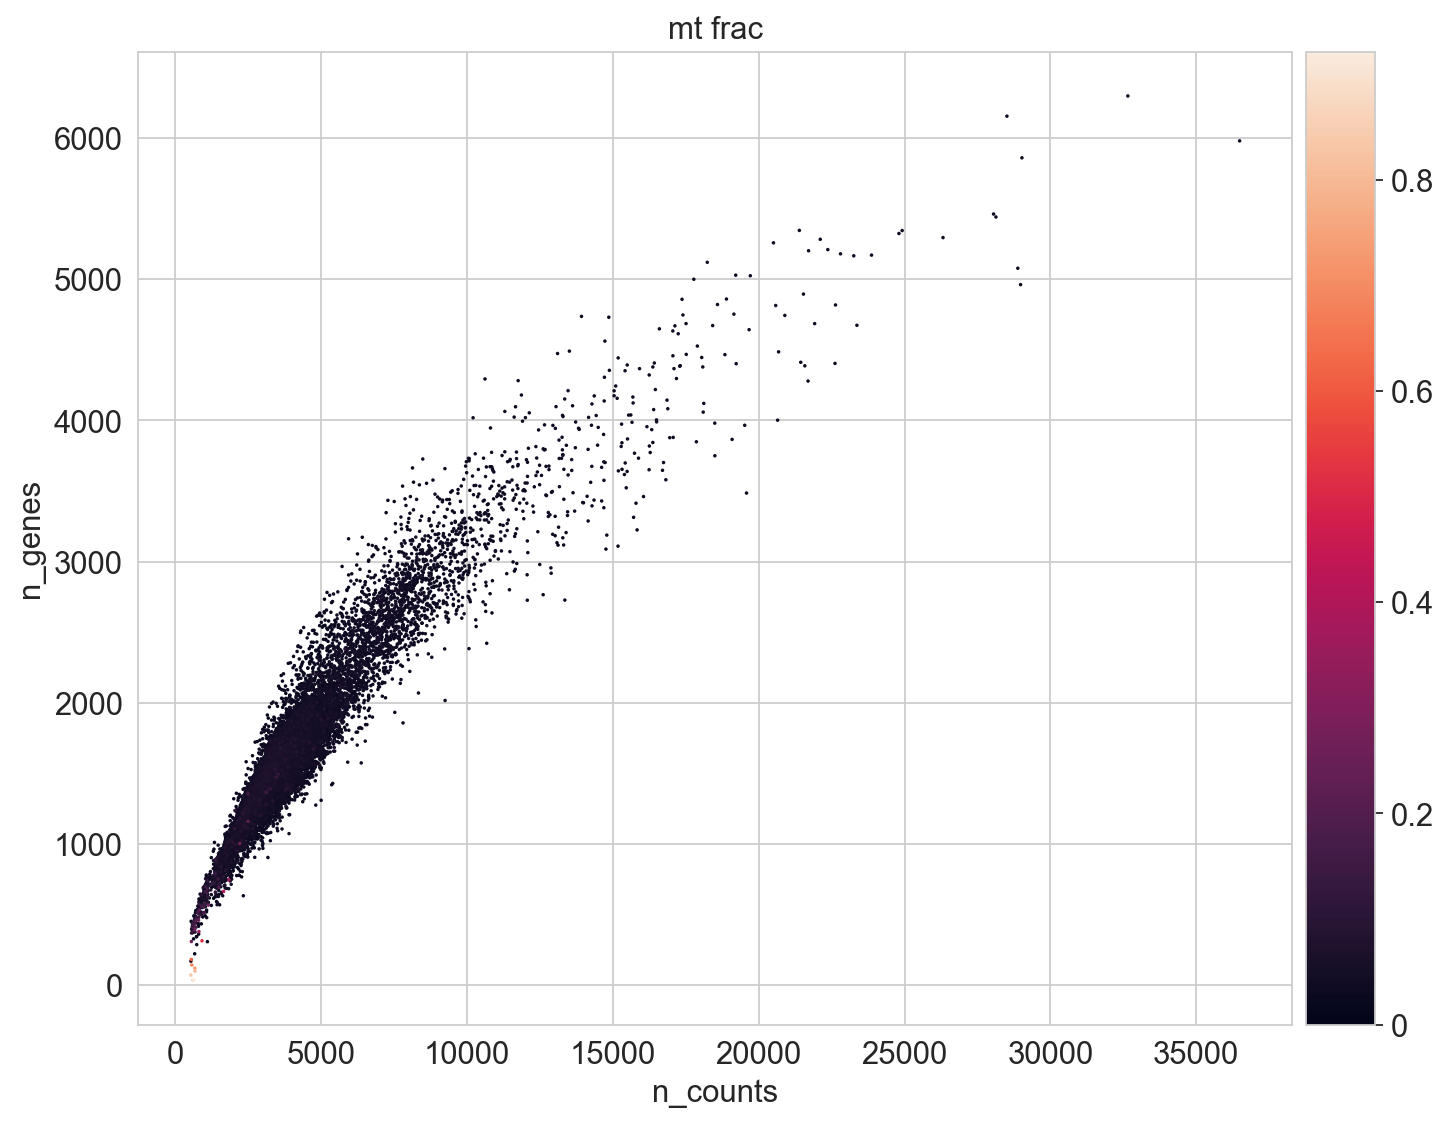

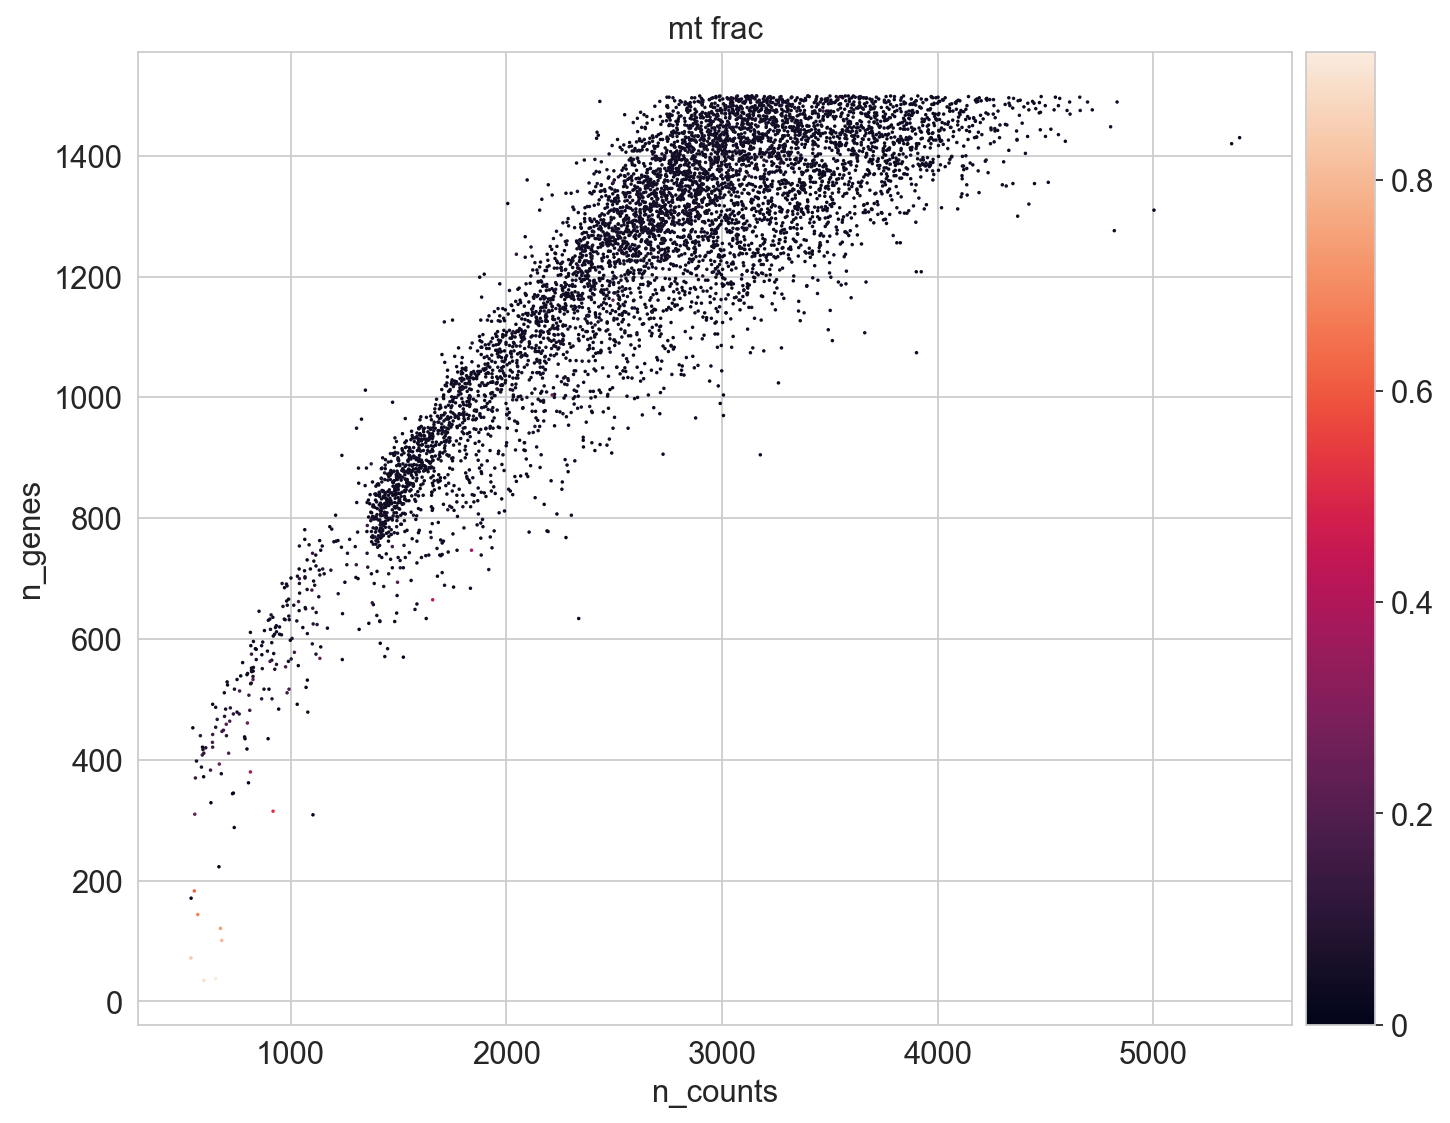

In [12]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color ='mt_frac', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1500, adata.obs['n_counts']<8000)],
         y='n_genes', x='n_counts', color='mt_frac', size=10, show=False)
plt.show()

### Apply Filtering

In [13]:
params_filter = {   'mt_frac': 0.1,
    'n_counts_min': 1200,
    'n_counts_max': 13000,
    'n_genes_min': 750,
}

In [14]:
print(f'Size before filtering: {len(adata)}')
adata = adata[adata.obs['mt_frac'] < params_filter['mt_frac']]
adata = adata[adata.obs['n_counts'] > params_filter['n_counts_min']]
adata = adata[adata.obs['n_counts'] < params_filter['n_counts_max']]
adata = adata[adata.obs['n_genes'] > params_filter['n_genes_min']].copy()
print(f'Size after filtering: {len(adata)}')
    
adata.shape

Size before filtering: 14693
Size after filtering: 14233


(14233, 36601)

## QC after filtering

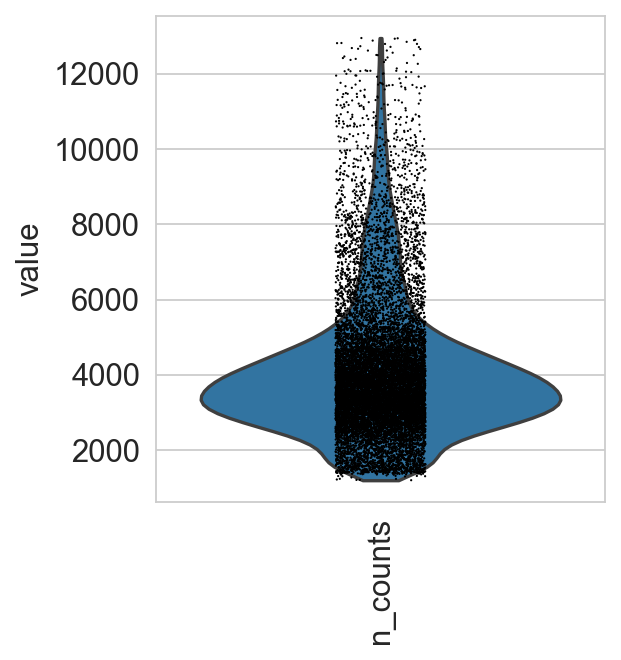

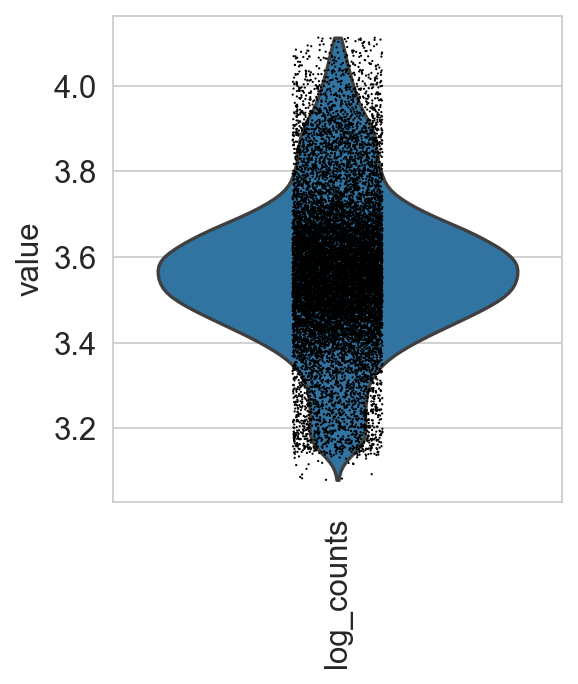

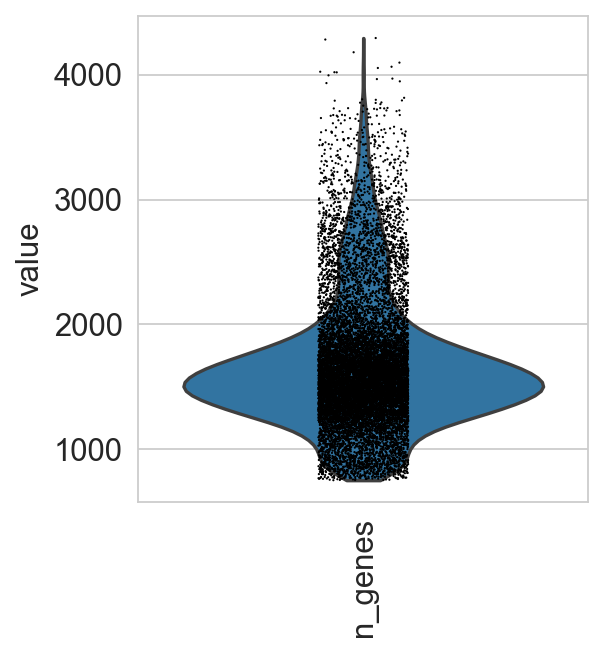

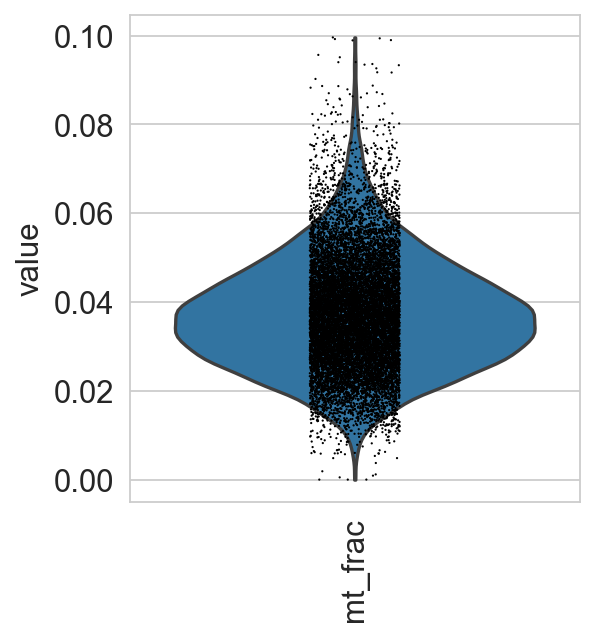

In [15]:
rcParams['figure.figsize'] = (4, 4)
sc.pl.violin(adata, ['n_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90)

## TCR stats

In [16]:
ir.tl.chain_pairing(adata)
adata.obs['chain_pairing'].value_counts()

single pair        8032
no IR              2703
orphan VDJ         1467
extra VJ            893
extra VDJ           591
two full chains     355
orphan VJ           192
Name: chain_pairing, dtype: int64

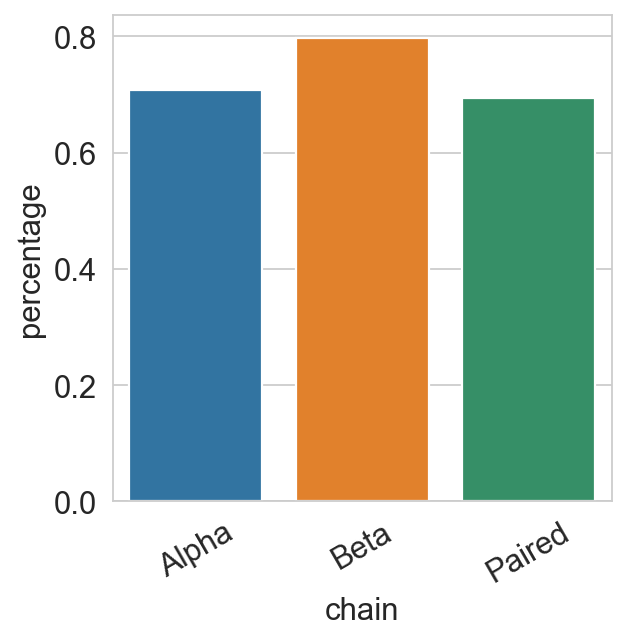

In [17]:
def get_percentages_tcr(data):
    p_alpha = data.obs['IR_VJ_1_junction_aa'].notnull().mean()
    p_beta = data.obs['IR_VDJ_1_junction_aa'].notnull().mean()
    p_paired = (data.obs['IR_VDJ_1_junction_aa'].notnull() & data.obs['IR_VJ_1_junction_aa'].notnull()).mean()
    return [p_alpha, p_beta, p_paired]

chains = ['Alpha', 'Beta', 'Paired']
percentages = get_percentages_tcr(adata)

df_tcr_fractions = {
    'chain': chains,
    'percentage': percentages
}

df_tcr_fractions = pd.DataFrame(df_tcr_fractions)
g = sb.barplot(data=df_tcr_fractions, y='percentage', x='chain')
_ = g.set_xticklabels(rotation=30, labels=g.get_xticklabels())

## Normalization

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## Quick Visual Sanity Check

In [ ]:
utils_representation.calculate_umap(adata, n_high_var=5000, remove_tcr_genes=True)
sc.pl.umap(adata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:03)


In [ ]:
rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(adata, color=['has_ir', 'chain_pairing'])
sc.pl.umap(adata, color=['n_counts', 'log_counts', 'n_genes', 'mt_frac'], ncols=2)

## Separate Donors

In [ ]:
utils_vis.distributions_over_columns(adata, hashtags, 2, 4)

In [ ]:
def hash_solo_by_sample(hashtag_cols, col_name, n_noise_barcodes):
    adata.obs[col_name] = 'NaN'

    dfs_donor = []
    adata.obs = adata.obs.drop(col_name, axis=1)
    sc.external.pp.hashsolo(adata, hashtag_cols, number_of_noise_barcodes=n_noise_barcodes)
    adata.obs = adata.obs.rename(columns={'Classification': col_name})

hash_solo_by_sample(hashtags, 'pool', 3)
adata.obs['pool'].value_counts()

In [ ]:
hash_solo_by_sample(hashtags, 'pool', 5)
adata.obs['pool'].value_counts()

In [ ]:
rcParams['figure.figsize'] = (16, 4)

for h in hashtags:
    adata.obs[f'log_{h}'] = np.log(adata.obs[h].values+1)
sb.violinplot(data=adata.obs[[f'log_{h}' for h in hashtags]], scale='area')

In [ ]:
utils_vis.adt_counts_by_condition(adata, hashtags, 'pool', 8, 4, do_log=True)

In [ ]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.umap(adata, color='pool')

In [ ]:
rcParams['figure.figsize'] = (8, 8)
adata_ha = ann.AnnData(X=adata.obs[adata.uns['hashtags']], obs=adata.obs[['pool']])
adata_ha.var_names = adata.uns['hashtags']
sc.pp.log1p(adata_ha)
sc.pp.neighbors(adata_ha)
sc.tl.umap(adata_ha)
sc.pl.umap(adata_ha, color=['pool'] + [f'HA{i}' for i in range(1, 8)], ncols=3, 
           save=f'/../../../../figures/mixed_run/sample_{sample}_hashtag_umap.pdf')

In [ ]:
rcParams['figure.figsize'] = (8, 8)
adata_ha = ann.AnnData(X=adata.obs[adata.uns['hashtags']], obs=adata.obs[['pool']])
adata_ha.var_names = adata.uns['hashtags']
sc.pp.log1p(adata_ha)
sc.pp.neighbors(adata_ha)
sc.tl.pca(adata_ha)
sc.pl.pca(adata_ha, color=['pool'] + [f'HA{i}' for i in range(1, 8)], ncols=3, 
           save=f'/../../../../figures/mixed_run/sample_{sample}_hashtag_pca.pdf')

In [ ]:
adata = adata[~adata.obs['pool'].isin(['Doublet', 'Negative'])]

## Remove Epitope Counts

In [ ]:
epitope_2_sample = {
    'LTDEMIAQY': ['HA1', 'HA2', 'HA3', 'HA4'],
    'QPYRVVVL': ['HA1', 'HA2', 'HA3', 'HA4'],
    'YLQPRTFLL': ['HA2'],
    'RLQSLQTYV': ['HA2'],
    'VLNDILSRL': ['HA2'],
    'KIADYNYKL': ['HA2'],
    'YTNSFTRGVY': ['HA3'],
    'NYNYLYRLF': ['HA3', 'HA4'],
    'TFEYVSQPFLMDLE': ['HA1', 'HA2', 'HA3', 'HA4'],
    'ATDSLNNEY': ['HA5', 'HA6', 'HA7'],
    'CTELKLSDY': ['HA5', 'HA6', 'HA7'],
    'FLRGRAYGL': ['HA5', 'HA6', 'HA7'],
    'RAKFKQLL': ['HA5', 'HA6', 'HA7']
}

In [ ]:
for e, samples in epitope_2_sample.items():
    adata.obs.loc[~adata.obs['pool'].isin(samples), e] = np.nan

## Remove Totalseq Counts

In [ ]:
samples_full_totalseq = ['HA1', 'HA2', 'HA3']
totalseq_2_custom = {
    'Hu.CD62L': 'CD62L', 
    'Hu.CD45RA': 'CD45RA', 
    'Hu.CD183': 'CXCR3'
}
unmatched_custom_id = ['CCR7']

In [ ]:
for old_id, new_id in totalseq_2_custom.items():
    adata.obs[new_id] = adata.obs[old_id].copy()
    adata.obs.loc[adata.obs['pool'].isin(samples_full_totalseq), new_id] = np.nan

for c in unmatched_custom_id:
    adata.obs.loc[adata.obs['pool'].isin(samples_full_totalseq), c] = np.nan

In [ ]:
for c in cite_seqs:
    adata.obs.loc[~adata.obs['pool'].isin(samples_full_totalseq), c] = np.nan

## Save

In [ ]:
adata.obs['pool'] = f'run_{sample}_' + adata.obs['pool'].astype(str)
sc.write(adata=adata, filename=path_merged)